In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# Define the transformations
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root = '../dataset'

# Initialize DatasetFolder for train and validation datasets
train_dataset = DatasetFolder(
    root=os.path.join(root, 'train'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)
test_dataset = DatasetFolder(
    root=os.path.join(root, 'val'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

In [3]:
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

In [4]:
batch_size = 60
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 27000
Val dataset size: 3000
Test dataset size: 7500
Image shape: torch.Size([1, 150, 150])
Classes: ['no', 'sphere', 'vort']
Image tensor type: torch.float32
Batches: 450


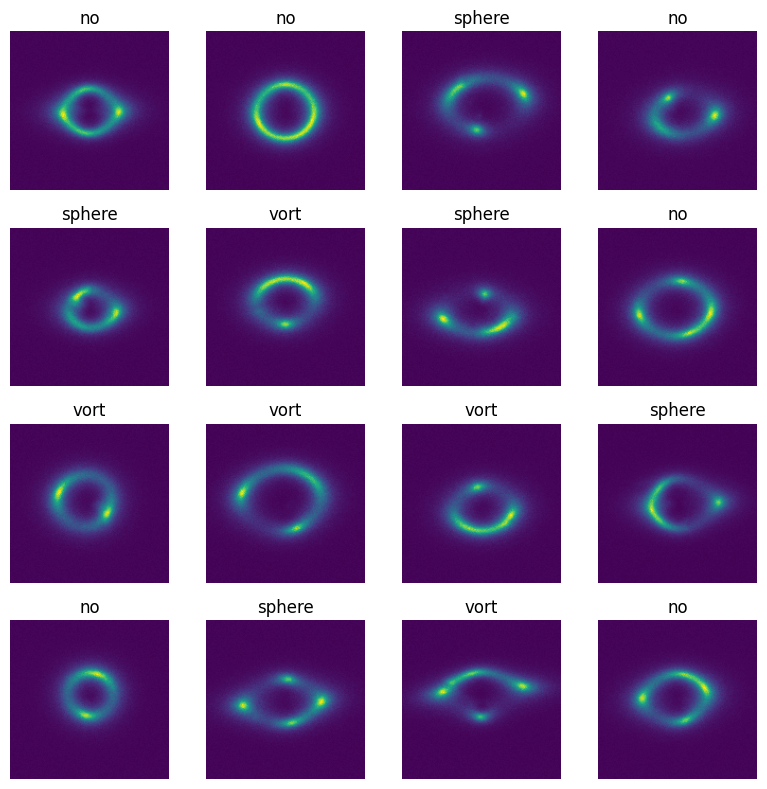

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

In [7]:
next(iter(train_loader))[0].shape

torch.Size([60, 1, 150, 150])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, idx = torch.max(outputs, 1)
            train_corrects += torch.sum(idx == labels.data).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, idx = torch.max(outputs, 1)
                val_corrects += torch.sum(idx == labels.data).item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_corrects / len(val_loader.dataset)

        # Step the scheduler
        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '../best_param_ViT.pt')

        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'\tTrain Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}')
        print(f'\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}')

        model.load_state_dict(torch.load('../best_param_ViT.pt'))

    return model

In [9]:
def evaluate_model(model, criterion, model_name):
    model.eval()
    y_pred_probs = []
    y_true = []
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, idx = torch.max(outputs, 1)
            total_corrects += torch.sum(idx == labels).item()

            y_pred_probs.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_corrects / len(test_loader.dataset)

    # Binarize the labels for ROC AUC
    y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovr')
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    classes = ['no', 'sphere', 'vort']

    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='icefire', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(np.array(y_true_binary).ravel(), np.array(y_pred_probs).ravel())
    plt.plot(fpr, tpr, color='orange', label=f'{model_name}, {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [10]:
def img_patch(images, num_patches):
    n, c, h, w = images.shape
    assert h == w, "Patch method is implemented for square images only"

    patches = torch.zeros(n, num_patches ** 2, h * w * c // num_patches ** 2)
    patch_size = h // num_patches

    for i, image in enumerate(images):
        for j in range(num_patches):
            for k in range(num_patches):
                patch = image[:, j * patch_size: (j + 1) * patch_size, k * patch_size: (k + 1) * patch_size]
                patches[i, j * num_patches + k] = patch.flatten()

    return patches

def get_positional_embeddings(seq_length, dim):
    result = torch.ones(seq_length, dim)

    for i in range(seq_length):
        for j in range(dim):
            result[i][j] = np.sin(i / (10000 ** (j / dim))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / dim)))

    return result

In [11]:
class MultiheadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super(MultiheadSelfAttention, self).__init__()
        self.dim = dim
        self.num_heads = num_heads

        assert dim % num_heads == 0, f"Can't divide dimension {dim} into {num_heads} heads"

        dim_head = int(dim / num_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(dim_head, dim_head) for _ in range(self.num_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(dim_head, dim_head) for _ in range(self.num_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(dim_head, dim_head) for _ in range(self.num_heads)])
        self.dim_head = dim_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, num_heads, token_dim / num_heads)
        # And come back to    (N, seq_length, item_dim) through concatenation
        result = []

        for sequence in sequences:
            seq_result = []
            
            for head in range(self.num_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.dim_head: (head + 1) * self.dim_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.dim_head ** 0.5))
                seq_result.append(attention @ v)

            result.append(torch.hstack(seq_result))

        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [12]:
class EncoderBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, mlp_ratio=4):
        super(EncoderBlock, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.mhsa = MultiheadSelfAttention(hidden_dim, num_heads)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, mlp_ratio * hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_dim, hidden_dim)
        )

    def forward(self, x):
        output = x + self.mhsa(self.norm1(x))
        output = output + self.mlp(self.norm2(output))

        return output

In [13]:
class ViTSD(nn.Module):
    def __init__(self, chw=(1, 150, 150), num_patches=15, num_blocks=4, hidden_dim=20, num_heads=4, out_dim=3):
        super(ViTSD, self).__init__()
        self.chw = chw # (C, H, W)
        self.num_patches = num_patches
        self.num_blocks = num_blocks
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        assert chw[1] % num_patches == 0, "Input shape is not divisible by number of patches"
        assert chw[2] % num_patches == 0, "Input shape is not divisible by number of patches"
        self.patch_size = (chw[1] / num_patches, chw[2] / num_patches)

        # Linear mapper
        self.input_dim = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_dim, self.hidden_dim)

        # Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_dim))

        # Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(num_patches ** 2 + 1, hidden_dim), persistent=False)

        # Encoder blocks
        self.blocks = nn.ModuleList([EncoderBlock(hidden_dim, num_heads) for _ in range(num_blocks)])

        # Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_dim, out_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Divide images into patches
        n, c, h, w = images.shape
        patches = img_patch(images, self.num_patches).to(self.positional_embeddings.device)

        # Run linear layer tokenization
        tokens = self.linear_mapper(patches)

        # Add the classification token to tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Add positional embedding
        output = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer blocks
        for block in self.blocks:
            output = block(output)

        # Get the classification token only
        output = output[:, 0]
        
        return self.mlp(output) # Map to output dimension, output category distribution

In [14]:
# Initialize the ViTSD model
model = ViTSD().to(device)

# Learning parameters
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.75)
criterion = nn.CrossEntropyLoss()

model

ViTSD(
  (linear_mapper): Linear(in_features=100, out_features=20, bias=True)
  (blocks): ModuleList(
    (0-3): 4 x EncoderBlock(
      (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (mhsa): MultiheadSelfAttention(
        (q_mappings): ModuleList(
          (0-3): 4 x Linear(in_features=5, out_features=5, bias=True)
        )
        (k_mappings): ModuleList(
          (0-3): 4 x Linear(in_features=5, out_features=5, bias=True)
        )
        (v_mappings): ModuleList(
          (0-3): 4 x Linear(in_features=5, out_features=5, bias=True)
        )
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=20, out_features=80, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=80, out_features=20, bias=True)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=20, out_features=3, bias=True)
    (1): Softmax(dim=

In [16]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)
print('Finished')

Epoch 1/20:
	Train Loss: 1.0993	Train Acc: 0.3374
	Val Loss: 1.0993	Val Acc: 0.3280


KeyboardInterrupt: 

In [15]:
model.load_state_dict(torch.load('../best_param_ViT.pt'))

<All keys matched successfully>

Test Loss: 1.0795
Accuracy: 0.4003
ROC AUC: 0.5839


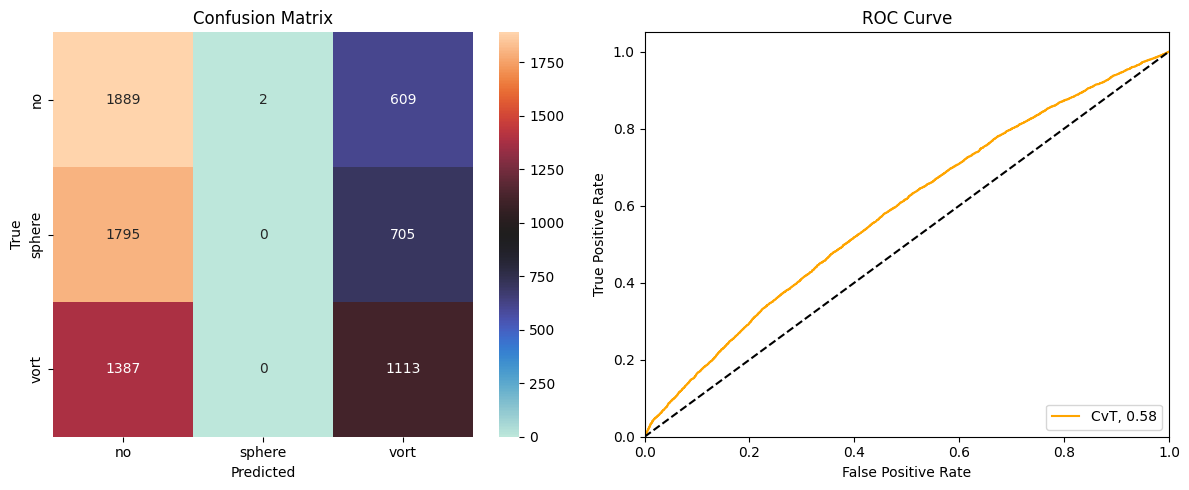

In [23]:
evaluate_model(model, criterion, 'ViTSD')